# AirBnB Case
by David Keller



### Load required libraries

In [1]:
import numpy as np
import pandas as pd
from operator import attrgetter

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns

from difflib import SequenceMatcher
import re

import json

import folium
import folium.plugins


from tqdm import tqdm
from dateutil.relativedelta import relativedelta
from datetime import datetime
%matplotlib inline

tqdm.pandas()

/usr/local/anaconda3/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


### Load airbnb Data

In [2]:
calendar = pd.read_csv('./data/airbnb_zurich/calendar.csv')
listings = pd.read_csv('./data/airbnb_zurich/listings.csv')
reviews = pd.read_csv('./data/airbnb_zurich/reviews.csv')

## Understand the Business of AirBnB

* What is the market offer in Zürich
   * Where are the best rooms?
   * What kind of appartment is typically for rent?
   * What are the prices?
* What can you tell about the reviewers in Zürich?
    * How does the number of reviews develop over time?
    * Are there effects over seasons, years or day of weeks for the reviews?
    * Are reviewers revisiting or changing their favourite rooms?
* How can you optimize your revenue on AirBnB as a host?
    * How can we model revenue?
    * How can we determine, what has an influence on the revenue?

## Market

### Question: What are the best scoring locations?

In [3]:
df_loc = listings[["latitude", "longitude", "review_scores_location"]]

Check if we have longitude and latitude for every listing.

In [4]:
df_loc.longitude.isnull().sum() == 0 and df_loc.latitude.isnull().sum() == 0

True

What percentage of location scores is NaN?

In [5]:
df_loc.review_scores_location.isnull().sum()/df_loc.shape[0]

0.20913978494623656

Roughly one fifth of rows are without a score for the location. We could either drop these before processing or inject a mean value. We follow the second approach here. If a guest does not review the location, we assume he has a neutral opinion here without ups or downs.

In [6]:
df_loc_filled = df_loc.fillna( value=df_loc.review_scores_location.mean(), axis=0 )

Make a plot to get an understanding of the best rated locations.

In [7]:
m = folium.Map(location = [df_loc_filled.latitude.mean(), df_loc_filled.longitude.mean()], tiles='Stamen toner', zoom_start = 12.)
folium.plugins.HeatMap( 
    df_loc_filled, name="Review Score Location", radius=10.,blur=10. ).add_to( m )
m

### Question: What kind of room is for rent?


#### Get an Idea of Room Types in Zürich

AirBnB has different room types in its database. A description is available [here](https://www.airbnb.com/help/article/5/what-does-the-room-type-of-a-listing-mean).
Do we have a room_type for every listing?

In [8]:
listings.room_type.notnull().all()

True

In [9]:
listings.room_type.value_counts()/listings.shape[0]

Entire home/apt    0.676882
Private room       0.310215
Shared room        0.008065
Hotel room         0.004839
Name: room_type, dtype: float64

Two thirds of the listings are entire homes. 31% are private rooms. Shared rooms and hotel rooms are negligible. 

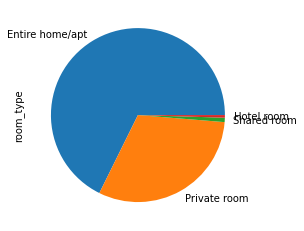

In [10]:
listings.room_type.value_counts().plot.pie()

#### Have a Look at Amenities

The amenities column contains a list of features. Take care, the list is in fact a string.

In [11]:
listings.amenities.head()

0    ["Hot tub", "Heating", "Elevator", "Dryer", "C...
1    ["Fire extinguisher", "Air conditioning", "Ind...
2    ["Stove", "Bed linens", "Elevator", "Microwave...
3    ["Lock on bedroom door", "Heating", "Elevator"...
4    ["Free parking on premises", "Heating", "Eleva...
Name: amenities, dtype: object

We split these into seperate columns for further processing.

In [12]:
def split_amenities( amenities_str ) :
    """
        Transform amenities from a string representation of a list into a pandas.Series which can be used to build new columns
        
        Parameters:
        amenities_list(str): A list of features in string representation
        
        Returns:
        pandas.Series: columns are lowercased entries of input list with blanks replaced by underscore, values are [True/False]
    
    """
    res = dict()
    for key in json.loads( amenities_str ) :
        res[key.lower().replace( " ", "_" )] = 1
    return pd.Series( res, dtype="bool" )

In [13]:
amenities = listings.amenities.progress_apply( split_amenities ).fillna( 0 )

100%|██████████| 1860/1860 [00:00<00:00, 2511.75it/s]


In [14]:
amenities.describe()

,hot_tub,heating,elevator,dryer,cable_tv,tv_with_standard_cable,washer,wifi,lake_access,essentials,...,clothing_storage:_walk-in_closet_and_wardrobe,soap_&_showergel_body_soap,"46""_hdtv_with_netflix",miele_electric_stove,la_roche_posay__body_soap,zug_stainless_steel_electric_stove,weleda_body_soap,pantene_shampoo,pool_table,paid_dryer
count,1860,1860,1860,1860,1860,1860,1860,1860,1860,1860,...,1860,1860,1860,1860,1860,1860,1860,1860,1860,1860
unique,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
top,0,True,0,True,0,0,True,True,0,True,...,0,0,0,0,0,0,0,0,0,0
freq,1820,1581,1051,1075,1328,1349,1274,1730,1710,1724,...,1859,1859,1859,1859,1859,1859,1859,1859,1859,1859


Amenities are not standardized but a manually written information by the hosts. Hence, we have quite some spread and possibly double entries. Have a look at the 30 most popular amenities and their percentage.

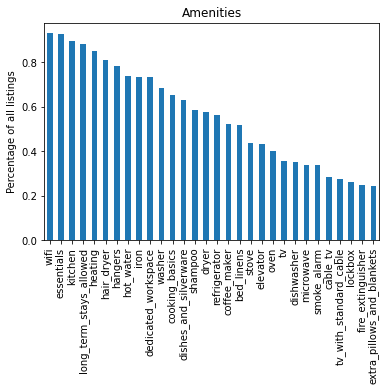

In [15]:
ax = (amenities.sum()/amenities.shape[0]).sort_values( ascending=False ).head(30).plot.bar()
ax.set_ylabel( "Percentage of all listings" );
ax.set_title( "Amenities" );

How many columns in amenities have only one single entry?

In [16]:
sparse_columns = amenities.loc[:,amenities.sum()==1].columns
print( sparse_columns )

Index(['gaggenau_oven', 'paid_parking_garage_on_premises_–_20_spaces',
       '55"_hdtv_with_apple_tv,_chromecast,_netflix,_standard_cable',
       'private_outdoor_heated_rooftop_pool', 'fast_wifi_–_248_mbps',
       'gaggenau_electric_stove', '55"_hdtv_with_netflix,_apple_tv',
       'dedicated_workspace:_desk,_table,_office_chair,_and_monitor',
       'nivea__body_soap', 'fast_wifi_–_271_mbps',
       ...
       'clothing_storage:_walk-in_closet_and_wardrobe',
       'soap_&_showergel_body_soap', '46"_hdtv_with_netflix',
       'miele_electric_stove', 'la_roche_posay__body_soap',
       'zug_stainless_steel_electric_stove', 'weleda_body_soap',
       'pantene_shampoo', 'pool_table', 'paid_dryer'],
      dtype='object', length=228)


There are 228 columns with only one entry. They cary valuable information. The description shows that they are quite specific in their formulation and could possibly be summarized in one of the more popular categories.

In order to get some more structure into amenities we make some data cleaning. Build a category dict by hand.

In [17]:
categories = {
    "stove" : re.compile( "stove|oven" ),
    "refigerator" : re.compile( "refigerator" ),
    "soap" : re.compile( "soap" ),
    "wifi" : re.compile( "wifi" ),
    "conditioner" : re.compile( "conditioner" ),
    "sound_system" : re.compile( "sound_system" ),
    "air_conditioning" : re.compile( "air_conditioning" ),
    "patio_or_balcony" : re.compile( "patio_or_balcony" ),
    "free_parking" : re.compile( "free_.*parking" ),
    "paid_parking" : re.compile( "paid_.*parking" ),
    "shampoo" : re.compile( "shampoo" ),
    "clothing_storage" : re.compile( "clothing_storage" ),
    "hair_dryer" : re.compile( "hair_dryer" ),
    "dryer" : re.compile( "^(?!hair_dryer).*dryer" ),
    "workspace" : re.compile( "workspace" ),
    "children’s_books_and_toys" : re.compile( "children’s_books_and_toys" ),
    "hot_tub" : re.compile( "hot_tub|rooftop_pool" ),
    "coffee_maker" : re.compile( "coffee_maker|nespresso_machine" ),
    "smoke_alarm" : re.compile( "smoke_alarm|carbon_monoxide_alarm" ),
    "tv" : re.compile( "^tv.*|.*tv$" ),
    "washer" : re.compile( "^(?!dish_washer).*washer" ),
    "dish_washer" : re.compile( "dish_washer" )
}

Add the top runners to the categories. Top runners are those columns with more than a given threshold portion not null:

In [18]:
def add_top_runner_to_categories( df, category, threshold ) :
    """
        add top runner categories from df to categories
        
        Parameter:
        df(DataFrame) : input dataframe
        category(dict) : dict with column names as keys and re's as values
        threshold(float) : only consider columns with >= threshold not null values
        
        Output:
        dict : new category dict
    """
    new_categories = categories.copy()
    for col in tqdm( amenities.columns ) :
        if ( amenities[col].sum()/amenities.shape[0] >= threshold ) :
            # make sure col is not yet matched by an already existing re
            double = False
            for excol, match in new_categories.items():
                if ( match.search(col) ) :
                    double = True
                    break
            if ( not double ) :
                new_categories[col] = re.compile( col )
    
    return new_categories

We concentrate on those with at least 5 percent not null entries:

In [19]:
new_categories = add_top_runner_to_categories( amenities, categories, 0.05 )

100%|██████████| 472/472 [00:00<00:00, 5961.80it/s]


In [20]:
def collapse_columns( df, categories ) :
    """
        Reduce the number of columns by their name. 
        Combines the values over collapsed columns into new columns by logical or operator.
        Raises a ValueError in case of overlapping categories.
        
        Parameter:
        df(DataFrame): input data with a numeric dtype
        categories(dict): a dict containing new column names as keys and re's to match on old column names.
        
        Returns:
        DataFrame: resulting df with a reduced number of columns 
        dict: a dictionary with a mapping fomr old column names to new column names
    
    """
    old_to_new = dict()
    df_new = pd.DataFrame( dtype="bool" )
    
    for cat, match in tqdm(categories.items()) :
        df_new[cat] = np.zeros( df.shape[0], dtype="bool" )
        for col in df.columns :
            if ( match.search( col ) ) :
                df_new[cat] |= df[col]
                if col in old_to_new.keys() :
                    raise ValueError( col )
                old_to_new[col] = cat
    
    
    return df_new, old_to_new

In [21]:
new_amenities, old_to_new = collapse_columns( amenities, new_categories )

100%|██████████| 66/66 [00:00<00:00, 435.71it/s]


new_amenities contains now 66 categories. Possible double entries are eliminated by hand.

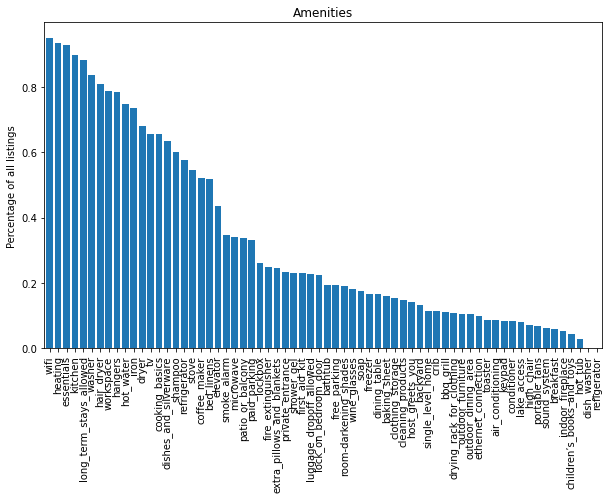

In [22]:
ax = (new_amenities.sum()/new_amenities.shape[0]).sort_values( ascending=False ).plot.bar( width=0.8, figsize=(10, 6) )
ax.set_ylabel( "Percentage of all listings" );
ax.set_title( "Amenities" );

What are the top-10 amenities with their percentage?

In [23]:
(new_amenities.sum()/new_amenities.shape[0]).sort_values( ascending=False ).head(10)

wifi                       0.949462
heating                    0.933871
essentials                 0.927957
kitchen                    0.897312
long_term_stays_allowed    0.882258
washer                     0.836022
hair_dryer                 0.809140
workspace                  0.786022
hangers                    0.783871
hot_water                  0.745699
dtype: float64

### What are the prices?

The price column seems to be a text column with a leading $ character:

In [24]:
listings.price.describe()

count       1860
unique       335
top       $80.00
freq          54
Name: price, dtype: object

In [25]:
listings.price.head(5)

0    $100.00
1    $195.00
2    $200.00
3     $60.00
4    $200.00
Name: price, dtype: object

Do we have a price for every listing?

In [26]:
listings.price.notnull().sum() == listings.shape[0]

True

Generate a new column containing the price as a float:

In [27]:
listings["dollar_price"] = listings.price.str.replace( "[$,]", "" ).astype(float)

Get an understanding of the prices:

In [28]:
listings.dollar_price.describe()

count    1860.000000
mean      178.495699
std       296.783855
min         0.000000
25%        76.000000
50%       113.500000
75%       190.000000
max      9840.000000
Name: dollar_price, dtype: float64

Interestingly, there is one 0 item:

In [29]:
(listings.dollar_price == 0).sum()

1

In [30]:
listings[listings.dollar_price==0.]

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,dollar_price
1375,46326518,https://www.airbnb.com/rooms/46326518,20211228000812,2021-12-28,citizenM Zurich,NaN,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,374971781,https://www.airbnb.com/users/show/374971781,...,4.75,4.56,NaN,f,1,0,0,0,1.45,0.0


It can be assumed, that this is not a valid listing. Meanwhile, the given url to the listing shows a non-zero price tag. Therefore we inject a mean-value as price for the further analysis:

In [31]:
listings['dollar_price'].replace( 0.0, listings.dollar_price.mean(), inplace=True)

How are the prices distributed in the market?

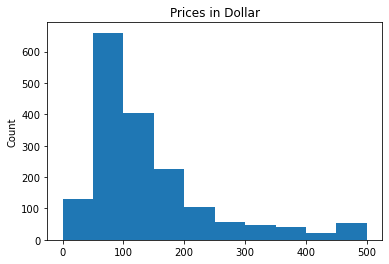

In [32]:
ax = listings.dollar_price.plot.hist(range=(0.0, 500.), title = "Prices in Dollar" )
ax.set_ylabel( "Count" );

## Question 2: What do the reviews tell us?

Reviews have grown since the beginning of the date-Series:

In [33]:
reviews.date = pd.to_datetime( reviews.date )

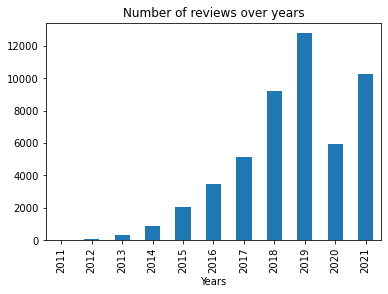

In [34]:
ax = reviews.id.groupby(reviews["date"].dt.year).count().plot(kind="bar", 
                                                         title="Number of reviews over years" )
ax.set_xlabel( "Years" );

The highest number of reviews is in 2019. 2020 shows a massive reduction of reviews going down to the level of 2017. This might be an effect of COVID19-regulations.

#### Do we have seasonal effects?

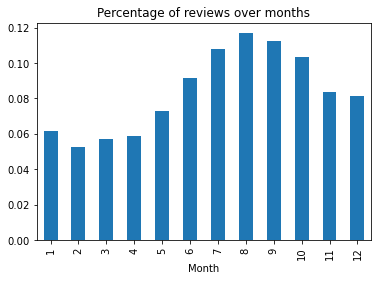

In [35]:
ax = (reviews.id.groupby(reviews["date"].dt.month).count()/reviews.shape[0]).plot(kind="bar", title="Percentage of reviews over months" )
ax.set_xlabel( "Month" );

There are more reviews during summer and late summer in Zürich than during winter or spring season.

The latest date in terms of the dataset is given by the scrape-date in listings and is the same over all listings:

In [36]:
listings.last_scraped = pd.to_datetime( listings.last_scraped )
now_date = listings.last_scraped.unique()
now_date

array(['2021-12-28T00:00:00.000000000'], dtype='datetime64[ns]')

Get all reviews within the last 365 days from now_date:

In [37]:
start_date = pd.DateOffset(days=-365)+pd.Timestamp( now_date[0] )
reviews_365 = reviews[reviews.date >= start_date]

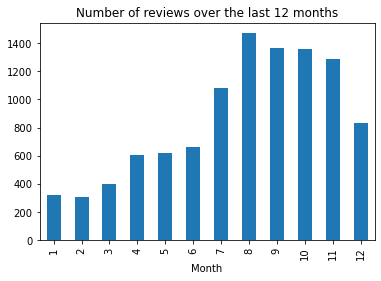

In [38]:
ax = reviews_365.id.groupby(reviews_365["date"].dt.month).count().plot(kind="bar", title="Number of reviews over the last 12 months");
ax.set_xlabel( "Month" );

Obviously we have a higher number of reviews in the second semester of 2021 than in the first. This might be due to COVID19-regulations reducing the number of bookings in the early months of the year. The 2021 distribution looks quite different to the one over all years above.

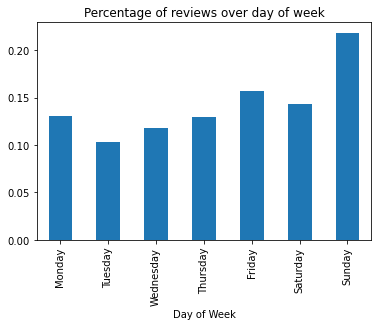

In [39]:
ax = (reviews.id.groupby(reviews["date"].dt.dayofweek).count()/reviews.shape[0]).plot(kind="bar", title="Percentage of reviews over day of week" )
ax.set_xlabel( "Day of Week" );
ax.set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]);

When looking at the day of week of the review, we see more than twenty percent on Sundays and only ten percent on Tuesdays.

How many reviewers do we have? Show the top ten reviewers with their number of reviews:

In [40]:
top_reviewers = reviews.reviewer_id.groupby( reviews.reviewer_id ).count().sort_values( ascending=False )
top_reviewers.head(10)

reviewer_id
15660298     31
86275054     27
373620484    22
101206495    19
54875964     18
82252732     18
56570592     17
66598705     16
114789754    15
31401851     15
Name: reviewer_id, dtype: int64

There are indications, that reviewers with multiple reviews, review the same listing more than once. Here are the reviews of the top candidate in the above list. Felix has written 31 reviews for one listing within three years:

In [41]:
reviews[reviews.reviewer_id==top_reviewers.index[0]]

,listing_id,id,date,reviewer_id,reviewer_name,comments
6389,3073966,60913472,2016-01-29,15660298,Felix,"Everything as described, Anto is a very kind h..."
6391,3073966,73898959,2016-05-11,15660298,Felix,I was in Zurich for work and had a good time a...
6393,3073966,75225840,2016-05-20,15660298,Felix,Again the stay at Anto's was just perfect. I c...
6394,3073966,83309570,2016-07-02,15660298,Felix,It's always again a pleasure staying at Anto's...
6395,3073966,85822316,2016-07-13,15660298,Felix,It's always again a pleasure staying at Anto's...
6397,3073966,100542822,2016-09-09,15660298,Felix,again I very much enjoyed my stay at Anto's!
6399,3073966,110409544,2016-10-26,15660298,Felix,it is always again great staying with Flo and ...
6400,3073966,114045591,2016-11-15,15660298,Felix,Always again great to stay at Anto's :)
6402,3073966,120127494,2016-12-08,15660298,Felix,"It's always again great staying at Anto's, nic..."
6403,3073966,127445634,2017-01-18,15660298,Felix,Always again great to stay with Flo & Anto!


In [42]:
def get_listing_count_of_reviewer( reviewer_id ) :
    """
        Function to extract the number of different listings reviewed by one reviewer
        
        Parameters:
        reviewer_id(int): the id of a reviewer
        
        Returns:
        the count of different listings the reviewer has written about
    """
    return  len( reviews[reviews["reviewer_id"]==reviewer_id].listing_id.unique() )

In [43]:
reviews["listing_count"] = np.vectorize( get_listing_count_of_reviewer, otypes=[np.int64] )( reviews.reviewer_id )

In [44]:
reviews[["reviewer_id", "reviewer_name", "listing_count"]].groupby(reviews.reviewer_id).first().sort_values( by="listing_count", ascending=False ).head(10)

,reviewer_id,reviewer_name,listing_count
reviewer_id,,,
82252732,82252732,Iyed,13
14160114,14160114,Bertrand,13
319015829,319015829,Holger,12
373620484,373620484,Jean-Philippe,12
54875964,54875964,Markus,11
4930439,4930439,Deniz,10
279392912,279392912,Micha,10
178831431,178831431,Bradac,10
38718918,38718918,Daniel,9


One can see, that Iyed and Betrand reviewed 13 different listings in Zürich.

## Question 3: How can you optimize your revenue as a host?
### Estimate the number of Bookings and Revenue

In the following we estimate the number of bookings, the duration of bookings and the earnings based on the "San Francisco Model" discussed [here](http://insideairbnb.com/about.html).

We assume, that 50 percent of guests write a review. Hence, we can double the number of reviews to estimate a total count of bookings for every listing. We do this for a future 12 month range based on the last 12 months:

In [45]:
listings["number_of_bookings_12m"] = listings.number_of_reviews_ltm * 2

Check if there are listings without estimated number of booked nights:

In [46]:
listings["number_of_bookings_12m"].isnull().any()

False

We assume an average length of stay of 3 nights per booking in general. If there is a minimum length of stay given by the host, we adjust the values to this minimum length. 

In [47]:
listings["average_length_of_stay"] = 3
listings["average_length_of_stay"].clip( lower=listings["minimum_nights_avg_ntm"], inplace=True )

The 12-month occupancy is estimated from the number of bookings and the average length. The total occupancy is capped to 70% according to the model given in the above link.

In [48]:
listings["estimated_occupied_nights"] = listings["number_of_bookings_12m"]*listings["average_length_of_stay"]
listings["estimated_occupied_nights"].clip( upper=0.7*365, inplace=True )

The estimated revenue is the product of estimated nights and price:

In [49]:
listings["estimated_revenue"] = listings["estimated_occupied_nights"].astype(float).multiply( listings["dollar_price"] )

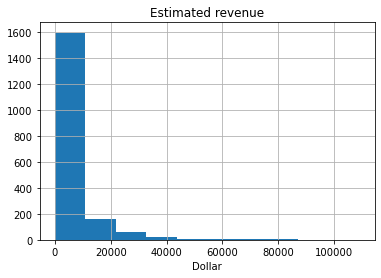

In [50]:
ax = listings["estimated_revenue"].hist()
ax.set_xlabel( "Dollar" )
ax.set_title( "Estimated revenue" );

Most revenues are in the range 0 to 10000 Dollars per year. But there are some top earners as well.
What are the top 10 earning hosts and their estimated revenue?

In [51]:
listings[["host_id", "estimated_revenue"]].groupby(listings["host_id"]).sum().sort_values( by="estimated_revenue", ascending=False ).head(10)

,host_id,estimated_revenue
host_id,,
475053,8550954,516103.5
23561865,871789005,480331.5
16703823,1236082902,428730.0
12886487,1172670317,344940.0
3528377,52925655,261726.0
13570663,502114531,259470.0
170040283,2380563962,228486.5
1788253,7153012,221230.0
83271512,1498887216,190806.5


### Build a model to predict revenue

Select numeric columns as input for the model.

In [153]:
num_vars = listings.select_dtypes( include=np.number )
num_vars.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,dollar_price,number_of_bookings_12m,average_length_of_stay,estimated_occupied_nights,estimated_revenue
count,1.860000e+03,1.860000e+03,1.860000e+03,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,0.0,1583.000000,...,1860.000000,1860.000000,1860.000000,1860.000000,1485.000000,1860.000000,1860.000000,1859.000000,1859.000000,1859.000000
mean,3.185799e+07,2.021123e+13,9.188792e+07,17.250538,17.250538,47.378094,8.532965,2.664516,NaN,1.296273,...,12.191398,11.123118,1.037634,0.023118,1.007367,178.591664,11.094624,7.913932,36.237224,4977.203335
std,1.669416e+07,1.641066e-01,1.208164e+08,41.211255,41.211255,0.018542,0.023476,1.589479,NaN,0.666162,...,23.734590,24.028054,2.477805,0.224873,1.433384,296.754964,23.391094,23.262811,59.271033,9708.463873
min,7.328200e+04,2.021123e+13,1.428800e+04,0.000000,0.000000,47.327670,8.466530,0.000000,NaN,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.010000,25.000000,0.000000,3.000000,0.000000,0.000000
25%,1.687292e+07,2.021123e+13,1.288649e+07,1.000000,1.000000,47.364722,8.519077,2.000000,NaN,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.180000,76.000000,0.000000,3.000000,0.000000,0.000000
50%,3.580429e+07,2.021123e+13,2.544453e+07,1.000000,1.000000,47.375310,8.532795,2.000000,NaN,1.000000,...,2.000000,1.000000,0.000000,0.000000,0.480000,114.000000,2.000000,3.000000,10.000000,1200.000000
75%,4.652906e+07,2.021123e+13,1.311793e+08,8.000000,8.000000,47.388238,8.548751,4.000000,NaN,1.000000,...,8.000000,6.000000,1.000000,0.000000,1.190000,190.000000,10.000000,5.000000,42.000000,5634.000000
max,5.401237e+07,2.021123e+13,4.367388e+08,175.000000,175.000000,47.431290,8.604800,16.000000,NaN,7.000000,...,91.000000,91.000000,18.000000,3.000000,15.140000,9840.000000,344.000000,365.000000,255.500000,108990.000000


Drop bathrooms, calendar, and license, since they are empty.

In [154]:
print( num_vars.bathrooms.isnull().all() )
print( num_vars.license.isnull().all() )
print( num_vars.calendar_updated.isnull().all() )
num_vars = num_vars.drop( ["bathrooms", "license", "calendar_updated"], axis=1 )

True
True
True


Drop IDs, since they can not explain the data.

In [155]:
num_vars = num_vars.drop( ["id","scrape_id", "host_id" ], axis=1 )

Drop longitude and latitude, we use the rating of the location instead.

In [156]:
num_vars = num_vars.drop( ["longitude", "latitude"], axis=1 )

Remove the temporary variables we introduced above.

In [157]:
num_vars = num_vars.drop( ["number_of_bookings_12m", "average_length_of_stay", "estimated_occupied_nights"], axis=1 )

Remove the calculated variables introduced by airbnbinside.

In [158]:
num_vars = num_vars.drop( [c for c in filter( lambda s : s.startswith( "calculated_" ), num_vars.columns.to_list() ) ], axis=1 )
num_vars = num_vars.drop( ["minimum_minimum_nights", "maximum_minimum_nights", "minimum_maximum_nights", "maximum_maximum_nights"], axis=1 )

Fill NaN values for the columns. First have a look at the portion of NaNs:

In [169]:
num_vars.isna().sum()/num_vars.shape[0]

host_listings_count            0.000000
host_total_listings_count      0.000000
accommodates                   0.000000
bedrooms                       0.148925
beds                           0.033333
minimum_nights                 0.000000
maximum_nights                 0.000000
minimum_nights_avg_ntm         0.000538
maximum_nights_avg_ntm         0.000538
availability_30                0.000000
availability_60                0.000000
availability_90                0.000000
availability_365               0.000000
number_of_reviews              0.000000
number_of_reviews_ltm          0.000000
number_of_reviews_l30d         0.000000
review_scores_rating           0.201613
review_scores_accuracy         0.209140
review_scores_cleanliness      0.209140
review_scores_checkin          0.209140
review_scores_communication    0.209140
review_scores_location         0.209140
review_scores_value            0.209140
reviews_per_month              0.201613
dollar_price                   0.000000


* Drop the rows, where we have NaN in estimated revenue - it is only 0.05 percent.
* Fill bedrooms and beds with mode, these are discrete in nature.
* Fill the reviews with a mean value. The are missing for 20 percent of the rows.
* Fill minimum_nights_avg_ntm and minimum_nights_avg_mtm with mean value.

In [172]:
num_vars = num_vars.dropna( subset=["estimated_revenue"], axis=0 )
num_vars["bedrooms"] = num_vars.bedrooms.fillna( num_vars.bedrooms.mode() )
num_vars["beds"] = num_vars.bedrooms.fillna( num_vars.beds.mode() )
fill_mean = lambda col : col.fillna( col.mean() )
num_vars = num_vars.progress_apply( fill_mean, axis=0 )

100%|██████████| 26/26 [00:00<00:00, 4710.26it/s]


#### Fit a model on the numeric variables

In [173]:
X = num_vars.drop( "estimated_revenue", axis=1 )
y = num_vars["estimated_revenue"]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=42 )

lm_model = LinearRegression( normalize=True )
lm_model.fit( X_train, y_train )

y_test_preds = lm_model.predict( X_test )

print( "The r-squared score for the model using only quantitative variables was %s on %s values." % (r2_score(y_test, y_test_preds), len(y_test)) )

The r-squared score for the model using only quantitative variables was 0.5835494067785963 on 558 values.


### TODO/FIXME

Convert price and adjusted_price column from string to float. Convert date.

In [52]:
calendar.price = calendar.price.str.replace( "[$,]", "" ).astype(float)
calendar.adjusted_price = calendar.adjusted_price.str.replace( "[$,]", "" ).astype(float)
calendar.date = pd.to_datetime( calendar.date )

Convert available column to bool

In [53]:
calendar.available.unique()

array(['f', 't'], dtype=object)

In [54]:
calendar["available_boolean"] = (calendar.available == "t")

How many available listings do we have for one year in the future?

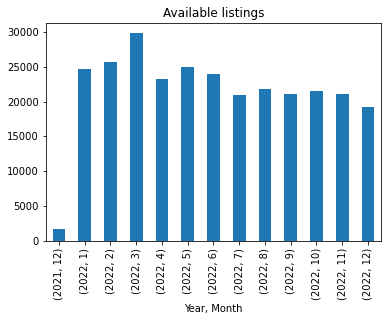

In [55]:
ax = calendar[calendar.available_boolean].available.groupby(
    [calendar["date"].dt.year, calendar["date"].dt.month]).count().plot(kind="bar", title="Available listings")
ax.set_xlabel( "Year, Month" );

In [56]:
review_count = pd.DataFrame( {"review_count" : reviews.listing_id.groupby( reviews["listing_id"] ).count()} )

In [57]:
new_listings = listings.join( review_count, on="id" )
new_listings.review_count.fillna( 0., inplace=True )

In [58]:
(new_listings.review_count == new_listings.number_of_reviews).all()

True

### Understand Data

In [59]:
listings.shape

(1860, 79)

In [60]:
calendar.shape

(678535, 8)

In [61]:
reviews.shape

(50245, 7)

In [62]:
listings.license.notna().count()

1860

In [63]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,listing_count
0,73282,1304820,2012-05-19,1787723,Jeff,Simona was an excellent hostess. The apartment...,3
1,73282,1448861,2012-06-10,2183393,Rick,"The apartment was fantastic - clean, beautiful...",1
2,73282,1574534,2012-06-27,2343568,Joseph,I stayed in the apartment for two weeks with m...,1
3,73282,1745571,2012-07-19,2343192,Yvonne,The apartment was everything and more. spaciou...,2
4,73282,2026650,2012-08-19,2092762,Joy,Simona's place is great! It's very quiet and ...,2


In [64]:
reviews.describe()

,listing_id,id,reviewer_id,listing_count
count,5.024500e+04,5.024500e+04,5.024500e+04,50245.000000
mean,1.908273e+07,6.993185e+16,1.042475e+08,1.243109
std,1.358630e+07,1.651534e+17,1.041389e+08,0.908976
min,7.328200e+04,3.066130e+05,3.369000e+03,1.000000
25%,6.293591e+06,2.333291e+08,2.288966e+07,1.000000
50%,1.790682e+07,4.563381e+08,6.555674e+07,1.000000
75%,2.750104e+07,6.503771e+08,1.582684e+08,1.000000
max,5.380350e+07,5.266430e+17,4.366466e+08,13.000000


### Work on Calendar Dataset

AirBnB has a mechanism to adjust prices dynamically. How does this mechanism work in our dataset? Check if price and adjusted_price have any difference:

In [65]:
calendar["price_difference"] = (calendar.price - calendar.adjusted_price)

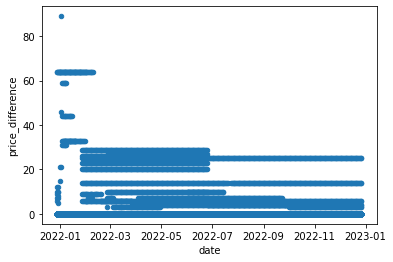

In [66]:
calendar[calendar.available_boolean].plot.scatter( x="date", y="price_difference" )

### Work on the Listings Dataset

In [67]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,dollar_price,number_of_bookings_12m,average_length_of_stay,estimated_occupied_nights,estimated_revenue
0,73282,https://www.airbnb.com/rooms/73282,20211228000812,2021-12-28,"Clean, central, quiet",Arty neighborhood<br /><br /><b>The space</b><...,NaN,https://a0.muscache.com/pictures/481072/abd94c...,377532,https://www.airbnb.com/users/show/377532,...,1,1,0,0,0.42,100.0,0,3.0,0.0,0.0
1,86645,https://www.airbnb.com/rooms/86645,20211228000812,2021-12-28,Stadium Letzigrund - by Airhome,Discover a boutique apartment presented by Air...,Located 300 meters to Zurich Letzigrund Stadio...,https://a0.muscache.com/pictures/miso/Hosting-...,475053,https://www.airbnb.com/users/show/475053,...,18,18,0,0,0.39,195.0,2,3.0,6.0,1170.0
2,143821,https://www.airbnb.com/rooms/143821,20211228000812,2021-12-28,marvelous LOFT in SIHLCITY Zürich,<b>The space</b><br />- 2.5 rooms on 2 floors ...,NaN,https://a0.muscache.com/pictures/1012249/a4f34...,697307,https://www.airbnb.com/users/show/697307,...,1,1,0,0,NaN,200.0,0,3.0,0.0,0.0
3,178448,https://www.airbnb.com/rooms/178448,20211228000812,2021-12-28,"a lovely place, top location","Very central location, 5 min walk from Bahnhof...","We live in one of the top locations of Zürich,...",https://a0.muscache.com/pictures/7d41e016-e818...,854016,https://www.airbnb.com/users/show/854016,...,1,0,1,0,0.07,60.0,0,5.0,0.0,0.0
4,204586,https://www.airbnb.com/rooms/204586,20211228000812,2021-12-28,very nice luxury city apartment,<b>The space</b><br />share a room in a very n...,NaN,https://a0.muscache.com/pictures/55486203/9834...,1004816,https://www.airbnb.com/users/show/1004816,...,1,0,1,0,NaN,200.0,0,3.0,0.0,0.0


Convert last_scraped to date. And extract the latest date in this column.

In [68]:
listings.last_scraped = pd.to_datetime( listings.last_scraped )
last_scraped_date = listings.last_scraped.max()
print("Last scraped date: %s" % last_scraped_date )

Last scraped date: 2021-12-28 00:00:00


In [69]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

Drop columns not relevant for our questions.

In [70]:
listings.drop( ["listing_url", "scrape_id", "last_scraped", "name", "description", "neighborhood_overview", "picture_url", "host_id", "host_url"], axis=1 )

,id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,...,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,dollar_price,number_of_bookings_12m,average_length_of_stay,estimated_occupied_nights,estimated_revenue
0,73282,Simona,2011-02-04,"Zurich, Zurich, Switzerland",I am from Italy and have lived in Zurich for a...,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/377532/profil...,...,1,1,0,0,0.42,100.0,0,3.0,0.0,0.0
1,86645,James,2011-03-31,Wherever you need me. Always happy to help.,Backed by an international team of guest suppo...,within an hour,98%,94%,t,https://a0.muscache.com/im/users/475053/profil...,...,18,18,0,0,0.39,195.0,2,3.0,6.0,1170.0
2,143821,Erhan,2011-06-13,"Zürich, Zurich, Switzerland",Hello everyone!\n\ni am living in Zurich.\n\nh...,within a day,100%,0%,f,https://a0.muscache.com/im/users/697307/profil...,...,1,1,0,0,NaN,200.0,0,3.0,0.0,0.0
3,178448,Delphine,2011-07-22,"Zurich, Zurich, Switzerland","I am a quiet, friendly and caring person\r\nI ...",NaN,NaN,0%,f,https://a0.muscache.com/im/users/854016/profil...,...,1,0,1,0,0.07,60.0,0,5.0,0.0,0.0
4,204586,Aicha,2011-08-22,"Zurich, Zurich, Switzerland","I'm a very active person, love traveling, cook...",NaN,NaN,NaN,f,https://a0.muscache.com/im/users/1004816/profi...,...,1,0,1,0,NaN,200.0,0,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1855,53987227,Carena,2016-05-30,"Zürich, Zurich, Switzerland",NaN,within a few hours,100%,67%,f,https://a0.muscache.com/im/pictures/user/9ceeb...,...,2,2,0,0,NaN,140.0,0,3.0,0.0,0.0
1856,53998419,Mia,2018-06-26,"Zürich, Zurich, Switzerland",A happy person that occasionally opens her hom...,within an hour,100%,77%,f,https://a0.muscache.com/im/pictures/user/ee075...,...,8,8,0,0,NaN,128.0,0,3.0,0.0,0.0
1857,54009704,Blueground,2021-12-01,"Zürich, Zurich, Switzerland",Why take a chance picking & choosing between s...,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/882cb...,...,7,7,0,0,NaN,237.0,0,31.0,0.0,0.0
1858,54012299,Blueground,2021-12-01,"Zürich, Zurich, Switzerland",Why take a chance picking & choosing between s...,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/882cb...,...,7,7,0,0,NaN,186.0,0,31.0,0.0,0.0


### Work on Reviews Dataset

Convert date-column to date-time.

How many unique reviewers do we have? Percentage of total number of reviews

In [71]:
len(reviews.reviewer_id.unique())/reviews.shape[0]

0.9079908448601851

In [72]:
How many reviews do we have per listing

SyntaxError: invalid syntax (<ipython-input-72-69b90f4c9bdd>, line 1)

In [ ]:
reviews.groupby( reviews.reviewer_id ).head()

#### Extract Sentiments from Comments

In [ ]:
sent = np.vectorize( textblob.TextBlob, reviews.comments.values )

In [ ]:
sent.sentiment

In [ ]:
pd.DataFrame( sent_pip( reviews.comments.to_list() ) )

In [ ]:
sent_pip?

### Join Datasets

In [ ]:
reviews.join( listings, "", "inner" )

### Playground

In [ ]:
te.get_emotion( reviews.comments.iat[0] )

In [ ]:
for i in range(10) :
        print( te.get_emotion( reviews.comments.iat[i] ))

In [ ]:
reviews.Happy = np.nan
reviews.Angry = np.nan
reviews.Surprise = np.nan
reviews.Sad = np.nan
reviews.Fear = np.nan

In [ ]:
reviews.comments.head(20).progress_apply( compute_emotions )

In [ ]:
def find_common_substring( str1, str2 ) :
    """
        Find a common substring in two strings
        
        Parameters:
        str1: first string
        str2: second string
        
        Returns:
        match-Object
    """
    return SequenceMatcher( None, str1, str2 ).find_longest_match(0, len(str1), 0, len(str2))

def reduce_columns_by_names_and_threshold( df, threshold = 0.01, min_substring_length = 12, categories = [] ) :
    """
        reduce the number of columns in a datafield (like amenities)
        
        Identifies columns with a contribution lower or equal threshold.
        Tries to find matching "parent" columns for these low-runner columns.
        Parents and children share a common portion of their column-name
        If a parent is identified: adds entries of parent and low-runner. Else: drops low-runner.
        
        Parameters:
        df(DataField): a Field containing numeric columns with string column-names
        threshold(Float): a percentage used to identify low-runners [0.0...1.0]
        min_substring_length(Integer): minimum length to consider as a match between column names
        categories(list of string): predefined list of strings for new column names
                                    if not present, the function generates its own new names
        
        Returns:
        Tuple(DataField, Dict): a new DataField generated through collapsing columns 
                                and a Dict describing the mapping from df-column-names to result-column-names
    
    """
    old_to_new_columns = dict()
    df_new = df
    
    
    # create a match matrix
    ##
    match_matrix = np.empty( (df.shape[1], df.shape[1]), dtype="object" )
    column_names = df.columns.to_list()
    for i, c1 in tqdm( enumerate( column_names ), desc="Computing match matrix", leave=True, total=len(column_names) ): 
        for j in range( i+1 ) :
            match_matrix[i,j] = match_matrix[j,i] = find_common_substring( c1, column_names[j] )
            
    # find the best match candidate for every column
    ##
    getsize = np.vectorize( attrgetter( "size" ) )
    match_sizes = getsize( match_matrix )
    np.fill_diagonal( match_sizes, 0 ) # diagonal entries have obviously a full match
    max_match_idx = np.argmax( match_sizes, axis=1 )
    
    for i, col in enumerate(column_names) :
        j = max_match_idx[i]
        if ( match_sizes[i, j] >= min_substring_length ) :
            new_name = column_names[i]
            old_to_new_columns[col] = old_to_new_columns[column_names[j]] = match_matrix[i, j].a
    
    
    print( old_to_new_columns )
    # find low runner columns
    low_runners = df.loc[:,df.sum()/df.shape[0] <= threshold]
    # find high runner column names
    high_runner_cols = [col for col in filter( lambda c : c not in low_runners.columns.to_list(), df.columns )]
    
    # iterate through all low_runners
    for lr in tqdm( low_runners, desc="Eliminating low-runners" ) :
        # compare col with all high_runners
        for hr in high_runner_cols :
            match = find_common_substring( lr, hr )
            # check if we have a match
            if ( match.size > min_substring_length ) :
                # add content of lr to hr column and drop lr column
                df_new[hr] += df_new[lr]
                df_new.drop( [lr], axis=1 )
                old_to_new_columns[lr] = hr
                break
        

    return df_new, old_to_new_columns
    